<a href="https://www.kaggle.com/heyrobin/credit-card-fraud-analysis?scriptVersionId=88482902" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><center> Credit Card Fraud Analysis and Prediction 👤💰</center></h1>
    

<center><img src="https://i.ibb.co/9mPwvKZ/1936a278707545.png"></center>

<center><strong>
        Source from 
        <a href="https://www.behance.net/gallery/78707545/Payment-Fraud-Protection?tracking_source=search_projects_recommended%7Ccredit%20card%20fraud" rel=" noreferrer nofollow">Behance</a>
        available 
        <a href="https://www.behance.net/gallery/78707545/Payment-Fraud-Protection?tracking_source=search_projects_recommended%7Ccredit%20card%20fraud" rel=" noreferrer nofollow">Here.</a>
    </strong>

**<span style="color:#4E3576;"> <span style="font-size:200%">  TABLE CONTENT</span>**


* [Analyzing the data](#1)
* [Treating the imbalance data](#2)
* [building a model](#3)
    
    <br>
    
Hello and greeting readers in this notebook we are going to analyze and predict fraudulent transactions from the data. Right now the notebook is on initial phase where I am updating it regularly with my trial and errors of finding best solution to perform the best predictive method to detect transactions.

<a id="1"></a>
# <center> <span style="font-family:Georgia"> <span style="color:white;font-weight:bold"> <span style="background:#4E3576"> 📕 Importing Libraries_ </span>

In [1]:
'''Libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Missing Values

In [4]:
df.isna().sum().sum()

print(f'There {df.isna().sum().sum()} Missing Values in the dataset')

There 0 Missing Values in the dataset


we found no missing values from the data which is a good news for further exploration and modeling


<a id="2"></a>
# <center> <span style="font-family:Georgia"> <span style="color:white;font-weight:bold"> <span style="background:#4E3576"> 📈 Exploratory Data Analysis </span><a id="1"></a>
    

**What is Imbalanced data?**

Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations. </br>Imbalance data will cause overfitting and lots of errors in algo.

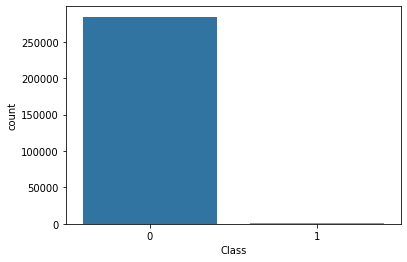

In [5]:
sns.countplot(df["Class"]);

Woah! there is very large diffrence between the class 0 and 1. It is an Imbalanced dataset<br>

## Scaling Features


After understanding the features of the data we saw that all the `V features` are scaled but the time and amount isnt. To create the completed scaled data for the independent features we will have to scale `Time` and `Amount`.

In [6]:
# scaling the non scaled features

from sklearn.preprocessing import RobustScaler

rob_scale = RobustScaler()

df['scaled_amount']=rob_scale.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_Time']=rob_scale.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount','Time'], axis=1,inplace=True)

### Undersampling Technique

Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is one of several techniques data scientists can use to extract more accurate information from originally imbalanced datasets.

In [7]:
legit = df[df["Class"] == 0]
fraud = df[df["Class"] == 1]


print(f'Legit: {fraud.Class.value_counts()[1]} & Fraud : {legit.Class.value_counts()[0]}')

Legit: 492 & Fraud : 284315


In [8]:
ls = legit.sample(n=492)
ls.Class.value_counts()

0    492
Name: Class, dtype: int64

In [9]:
df2 = pd.concat([fraud,ls], axis = 0)

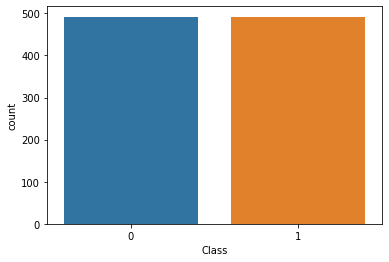

In [10]:
sns.countplot(df2["Class"]);

The class has been balanced by equal values. Lets perform modeling on this new balanced data

## Features Correlation

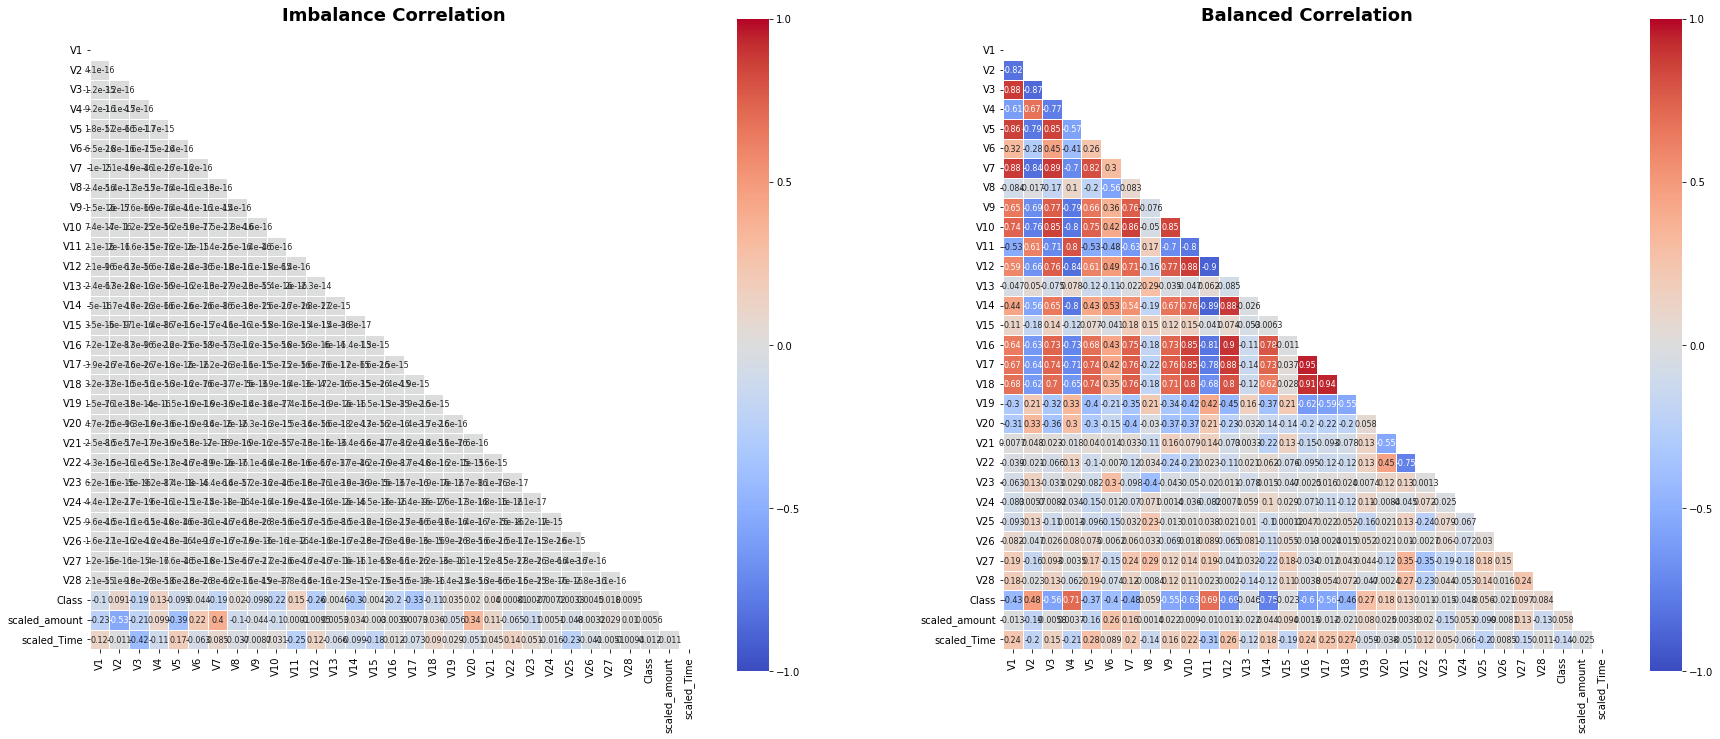

In [11]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True


f, axes = plt.subplots(ncols=2, figsize=(30,30))

heatmap = sns.heatmap(df.corr(),
            mask = mask,
            square = True,
            linewidths = .5,
            cmap = 'coolwarm',
            cbar_kws = {'shrink': .4,"ticks" : [-1, -.5, 0, 0.5, 1]},
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws = {"size": 8},
            ax = axes[0])

axes[0].set_title('Imbalance Correlation', size = 18, weight='bold', pad=20);

heatmap = sns.heatmap(df2.corr(),
            mask = mask,
            square = True,
            linewidths = .5,
            cmap = 'coolwarm',
            cbar_kws = {'shrink': .4,"ticks" : [-1, -.5, 0, 0.5, 1]},
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws = {"size": 8},
            ax = axes[1])

axes[1].set_title('Balanced Correlation', size = 18, weight='bold', pad=20);

### **Correlation Matrices**

Correlation is a table that shows the relation between 2 features. It helps to understand data more deeply. With colors and heatmap chart it helps you to visualize and spot difference very efficiently.

<blockquote><b>📌 Summary:</b>
<ul>
    <li> <code>Positively Correlated:</code>  V2, V4, V11,and V19 are <em>positively correlated</em> with class.</li>
    <li> <code>Negetively Correlated:</code> V3, V7, V10, V12, V14, V17 are <em>negetively correlated</em> with class.</li>
    </ul>
</blockquote>

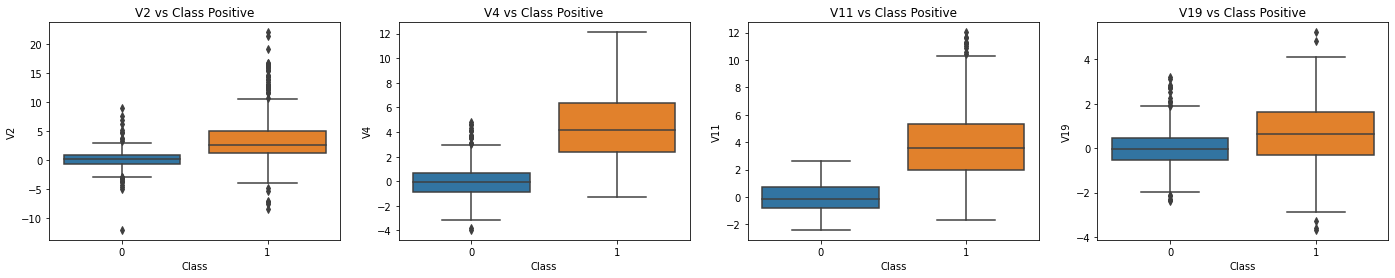

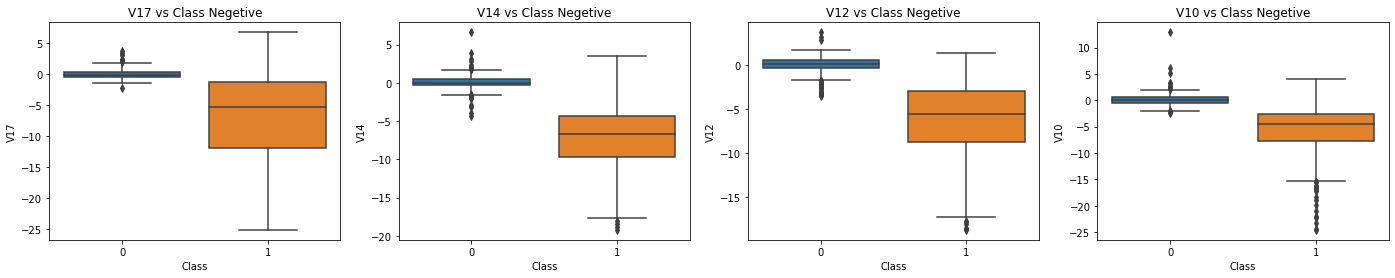

In [12]:
f, axes = plt.subplots(ncols=4, figsize=(24,4))

sns.boxplot(data=df2, x="Class", y="V2", ax=axes[0])
axes[0].set_title("V2 vs Class Positive")

sns.boxplot(data=df2, x="Class", y="V4", ax=axes[1])
axes[1].set_title("V4 vs Class Positive")

sns.boxplot(data=df2, x="Class", y="V11", ax=axes[2])
axes[2].set_title("V11 vs Class Positive")

sns.boxplot(data=df2, x="Class", y="V19", ax=axes[3])
axes[3].set_title("V19 vs Class Positive");


f, axes = plt.subplots(ncols=4, figsize=(24,4))

sns.boxplot(data=df2, x="Class", y="V17", ax=axes[0])
axes[0].set_title("V17 vs Class Negetive")

sns.boxplot(data=df2, x="Class", y="V14", ax=axes[1])
axes[1].set_title("V14 vs Class Negetive")

sns.boxplot(data=df2, x="Class", y="V12", ax=axes[2])
axes[2].set_title("V12 vs Class Negetive")

sns.boxplot(data=df2, x="Class", y="V10", ax=axes[3])
axes[3].set_title("V10 vs Class Negetive");




<a id="3"></a>
# <center> <span style="font-family:Georgia"> <span style="color:white;font-weight:bold"> <span style="background:#4E3576"> 🦾 Model </span><a id="1"></a>
    

We already balanced the data now we will train on the model

In [13]:
#spliting the data for target and features
X = df2.drop(columns='Class', axis=1)
y = df2['Class']

In [14]:
#creating the test train split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

In [15]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [16]:
models = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [17]:
from sklearn.model_selection import cross_val_score


def training_model():
    
    for key, model in models.items():
        model.fit(X_train,y_train)
        cv_score = cross_val_score(model,X_train,y_train,cv=5)
        print("Classifiers: ", key, "Has a training score of", round(cv_score.mean(), 2) * 100, "% accuracy score")

In [18]:
training_model()

Classifiers:  LogisiticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNearest Has a training score of 93.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 94.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


<blockquote><b>📌 Summary:</b>
<ul>
    <li> Now We have trained the model with the balanced dataset and the accuracy is around <code>95%</code> for this model.</li>
    <li> the <code>f1 score</code> is <code>95%</code> and <code>94%</code> for both classes which is very fit but can we improve the model further for good accuracy?</li>
    </ul>
</blockquote>

## <center> <span style="font-family:Georgia"> <span style="color:white;font-weight:bold"> <span style="background:#4E3576">🚧 Work in Progress 🚧</span>
## <center> <span style="font-family:Georgia"> <span style="color:white;font-weight:bold"> <span style="background:#4E3576">✌️ If you like my notebook and found it usefull please do upvote</span>